### Portfolio Optimization of the 5 stocks of BankNifty
1. Using yfinance Lib for the data.
2. Analysis of moving average in different timeline.
3. Distribution of Daily return of stocks.
4. Correlation of the stocks.
5. Optimmization using MPT(Modern Portfolio Theory).
6. Visualization with expected Return and Volatility.
7. Sharpe ratio of Portfolio and each stocks

**Step 1:** Importing the required librarys

In [76]:
import pandas as pd
import yfinance as yf
from datetime import date, timedelta

# define the time period for the data
end_date = date.today().strftime("%Y-%m-%d")
start_date = (date.today() - timedelta(days=100)).strftime("%Y-%m-%d")

# list of stock tickers to download
tickers = ['ICICIBANK.NS',  'HDFCBANK.NS','KOTAKBANK.NS','AXISBANK.NS','BANKBARODA.NS']

data = yf.download(tickers, start=start_date, end=end_date, progress=False)

# reset index to bring Date into the columns for the melt function
data = data.reset_index()

# melt the DataFrame to make it long format where each row is a unique combination of Date, Ticker, and attributes
data_melted = data.melt(id_vars=['Date'], var_name=['Attribute', 'Ticker'])

# pivot the melted DataFrame to have the attributes (Open, High, Low, etc.) as columns
data_pivoted = data_melted.pivot_table(index=['Date', 'Ticker'], columns='Attribute', values='value', aggfunc='first')

# reset index to turn multi-index into columns
stock_data = data_pivoted.reset_index()

print(stock_data.head())


Attribute       Date         Ticker    Adj Close        Close         High  \
0         2024-04-26    AXISBANK.NS  1129.428345  1130.300049  1141.349976   
1         2024-04-26  BANKBARODA.NS   260.770447   268.049988   272.700012   
2         2024-04-26    HDFCBANK.NS  1489.460815  1509.800049  1528.000000   
3         2024-04-26   ICICIBANK.NS  1107.900024  1107.900024  1120.000000   
4         2024-04-26   KOTAKBANK.NS  1606.739014  1608.500000  1655.000000   

Attribute          Low         Open      Volume  
0          1123.000000  1130.000000  10133766.0  
1           267.350006   270.000000  14775940.0  
2          1505.550049  1519.800049  12427347.0  
3          1102.750000  1112.150024  14190059.0  
4          1605.000000  1642.449951  22146849.0  


**DATA:** The data is collected for last 100 days of the below stocks
1. ICICI Bank 2. Bank Of Baroda 3. HDFC Bank 4. AXIS Bank 5. Kotak Bank

**Step 2:** Performance and Moving Average of the stocks

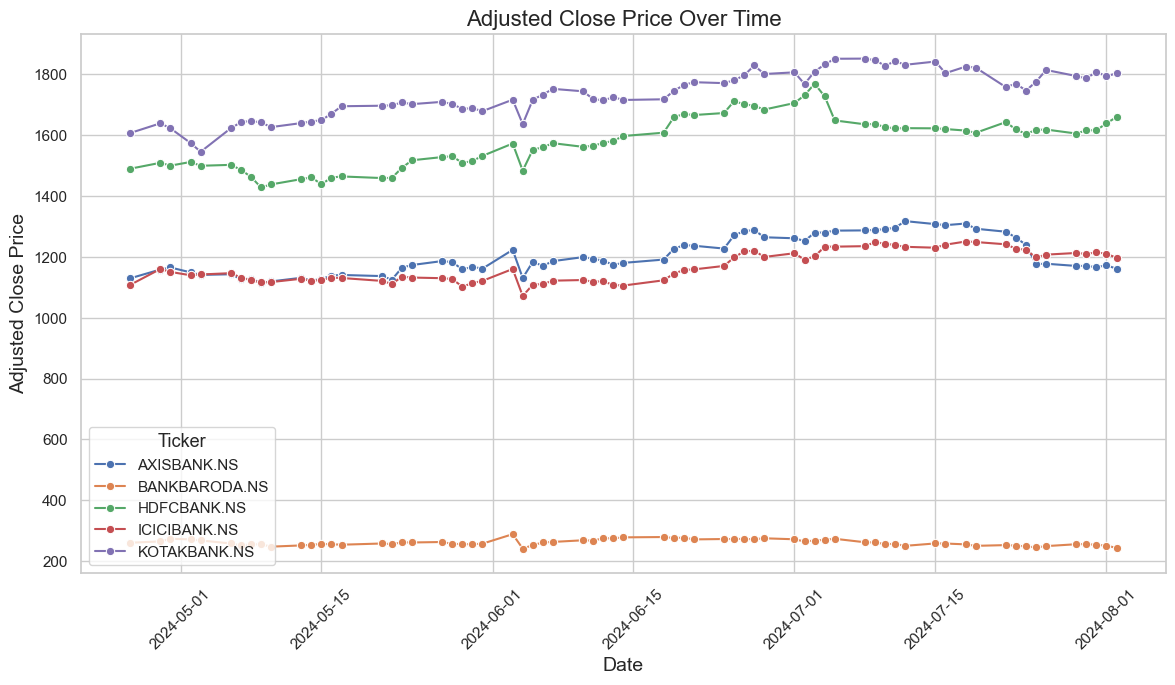

In [77]:
import matplotlib.pyplot as plt
import seaborn as sns

stock_data['Date'] = pd.to_datetime(stock_data['Date'])

stock_data.set_index('Date', inplace=True)
stock_data.reset_index(inplace=True)
plt.figure(figsize=(14, 7))
sns.set(style='whitegrid')

sns.lineplot(data=stock_data, x='Date', y='Adj Close', hue='Ticker', marker='o')

plt.title('Adjusted Close Price Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Adjusted Close Price', fontsize=14)
plt.legend(title='Ticker', title_fontsize='13', fontsize='11')
plt.grid(True)

plt.xticks(rotation=45)

plt.show()

Performance of every stock can be seen considering the Adjusted price over time. Its shows that Axis Bank and HDFC bank has highest adjusted close price, followed by Kotak Bank, ICICI Bank, Bank Of Baroda.


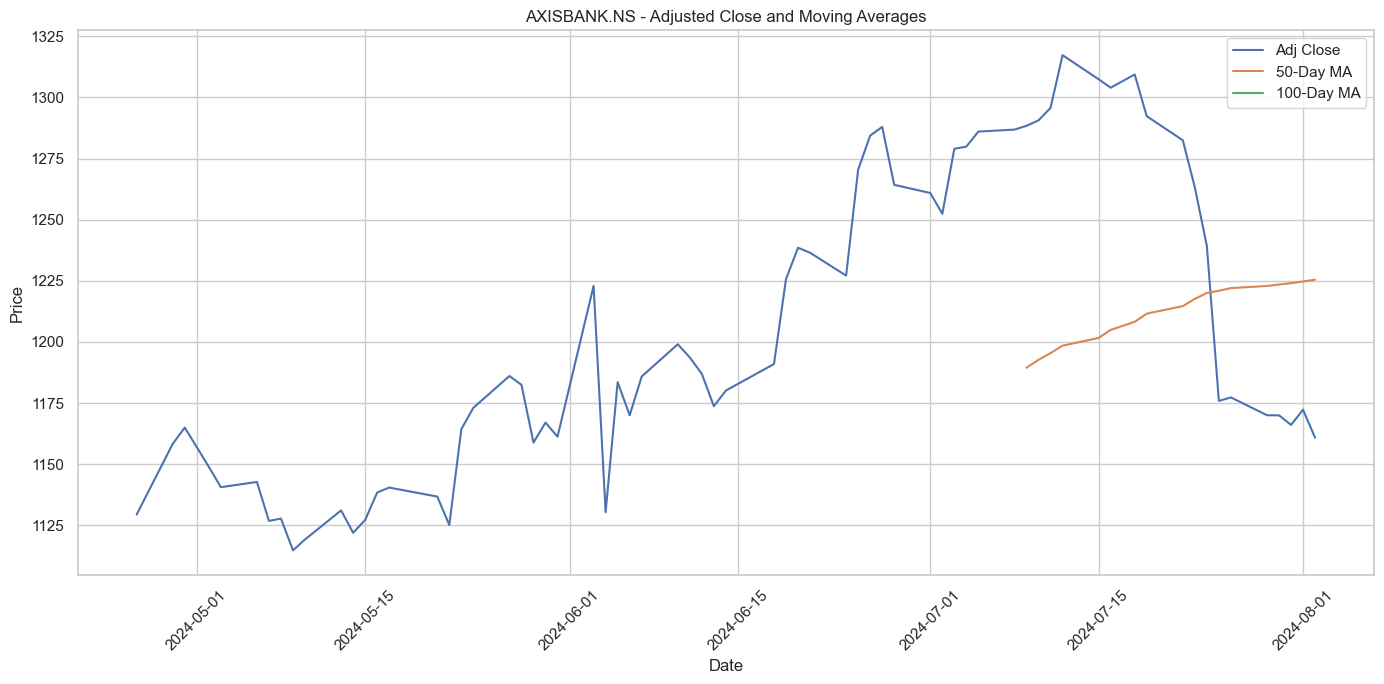

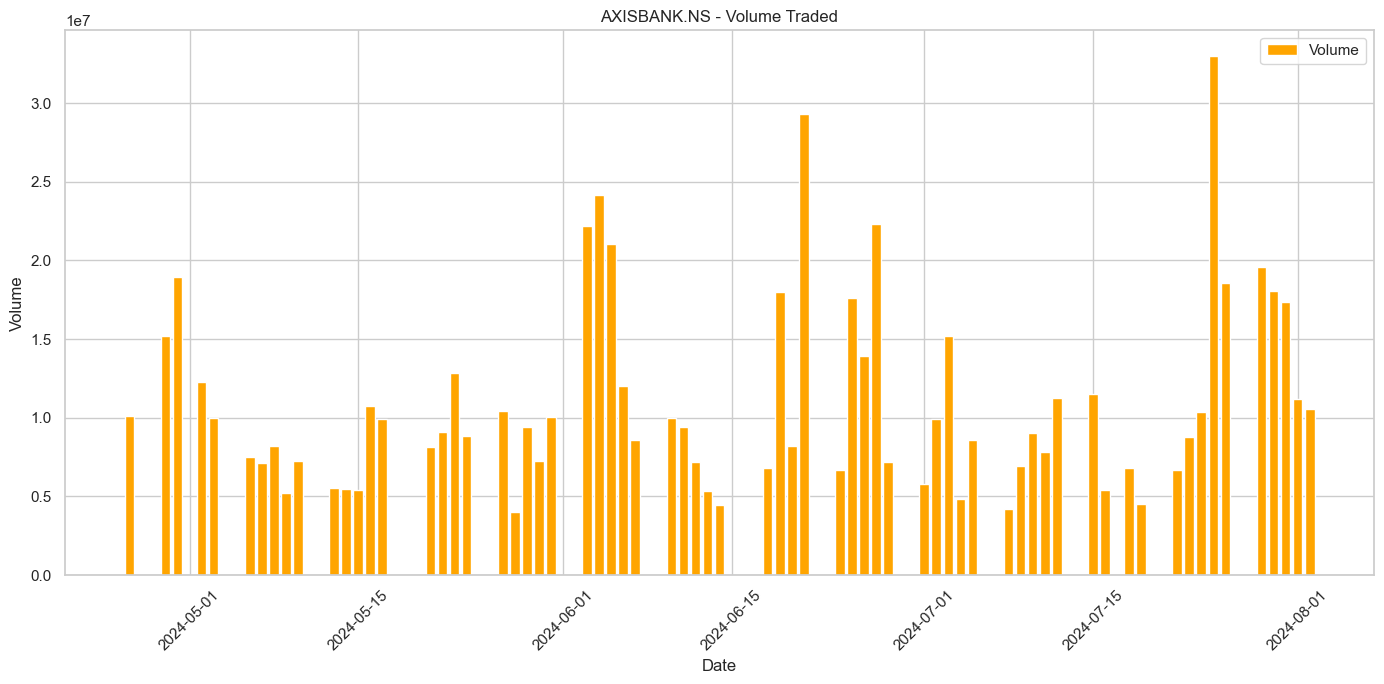

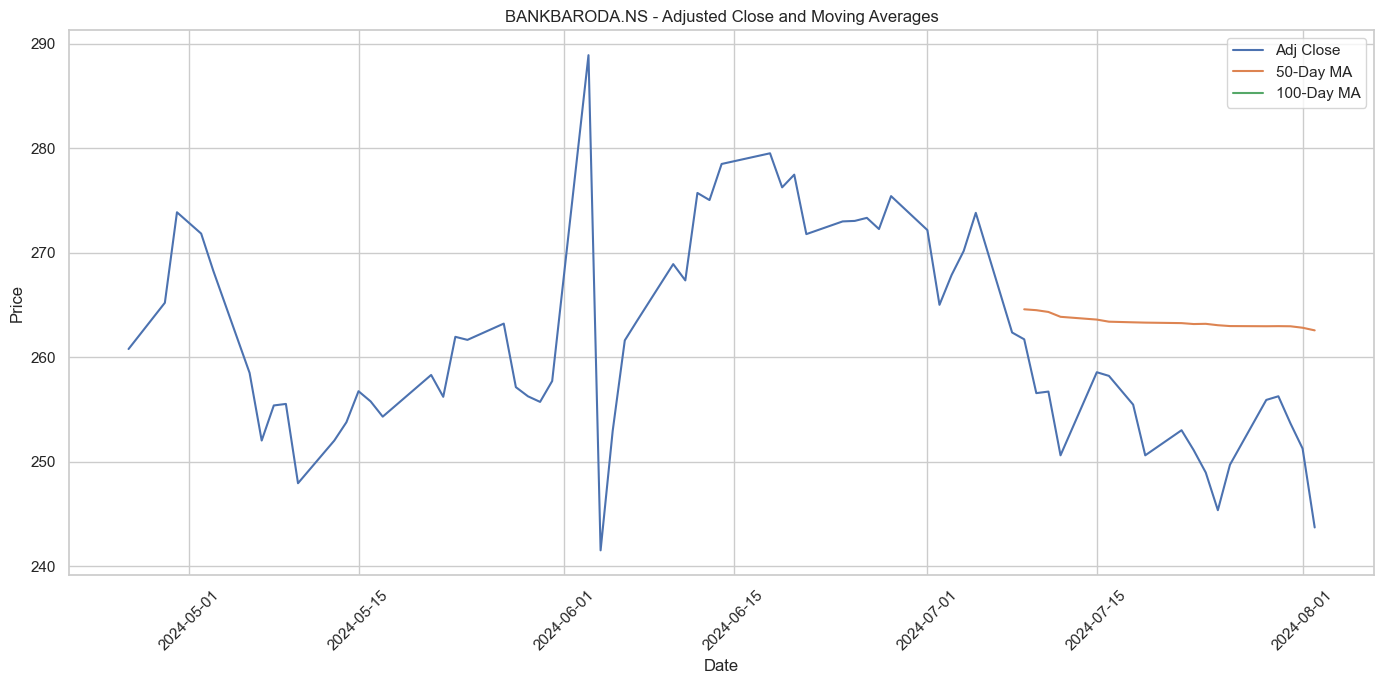

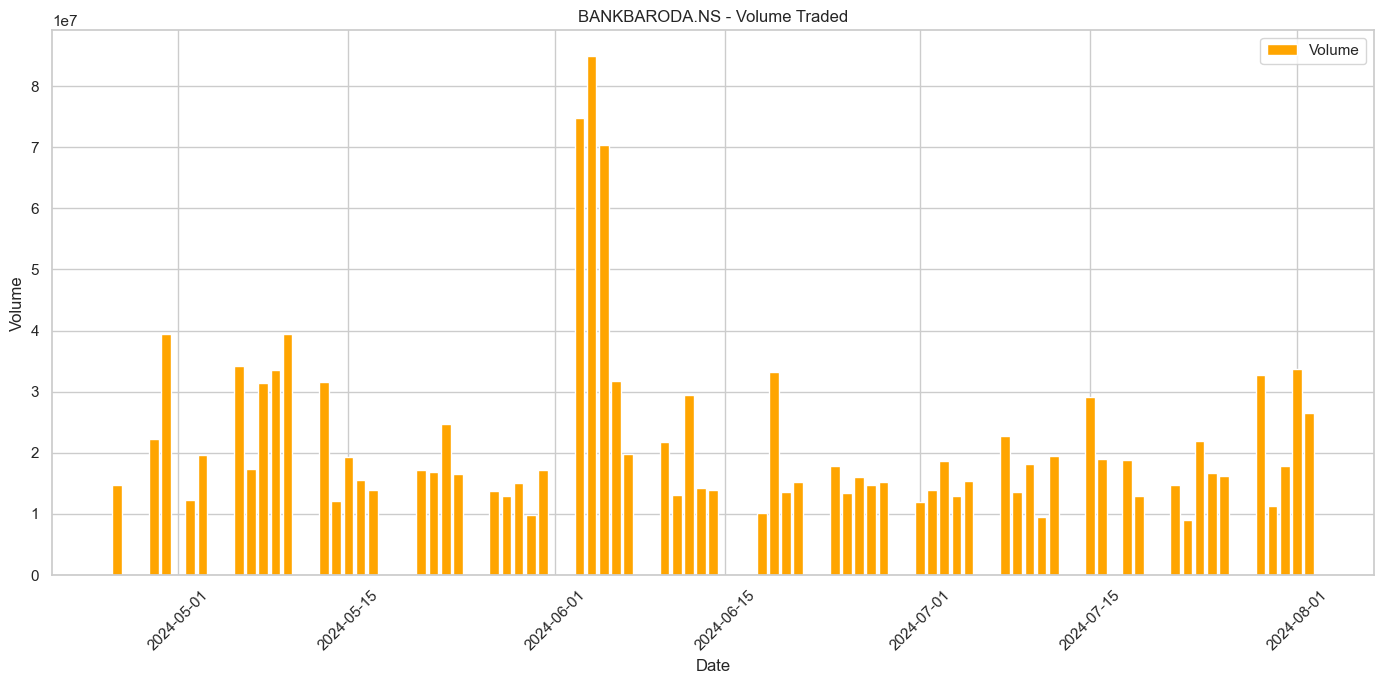

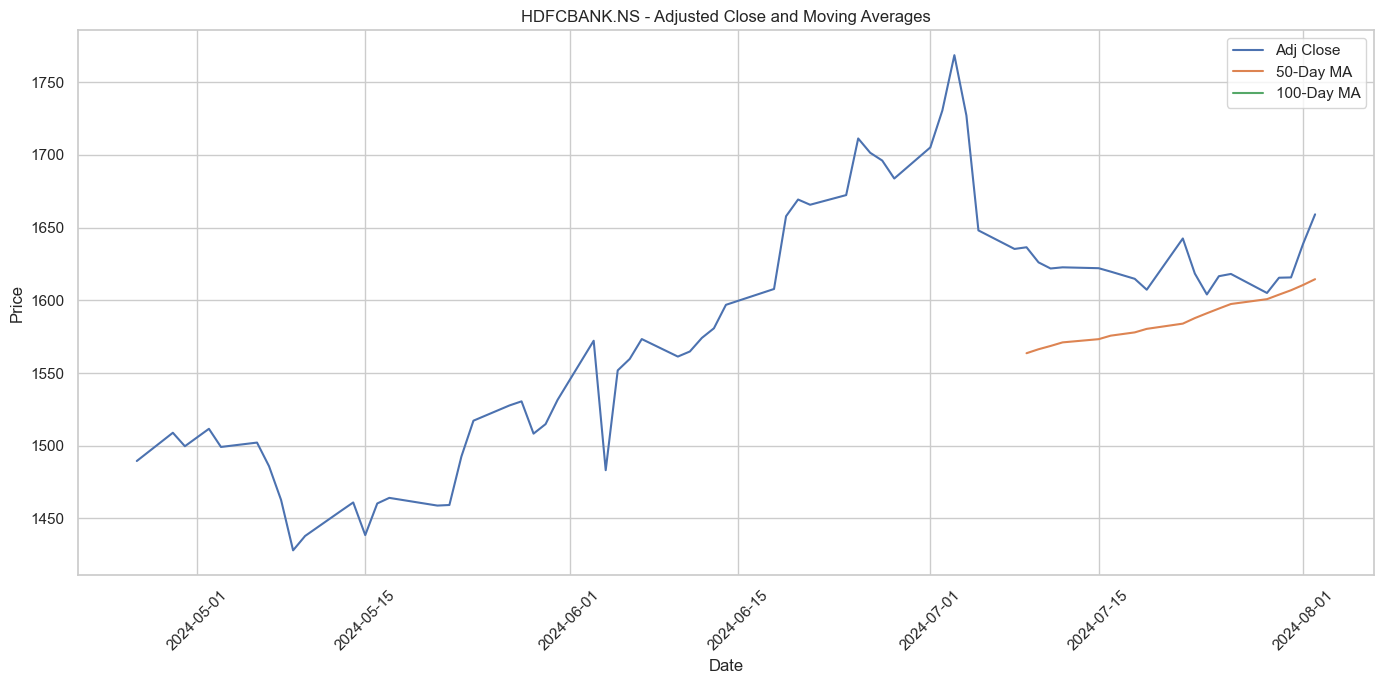

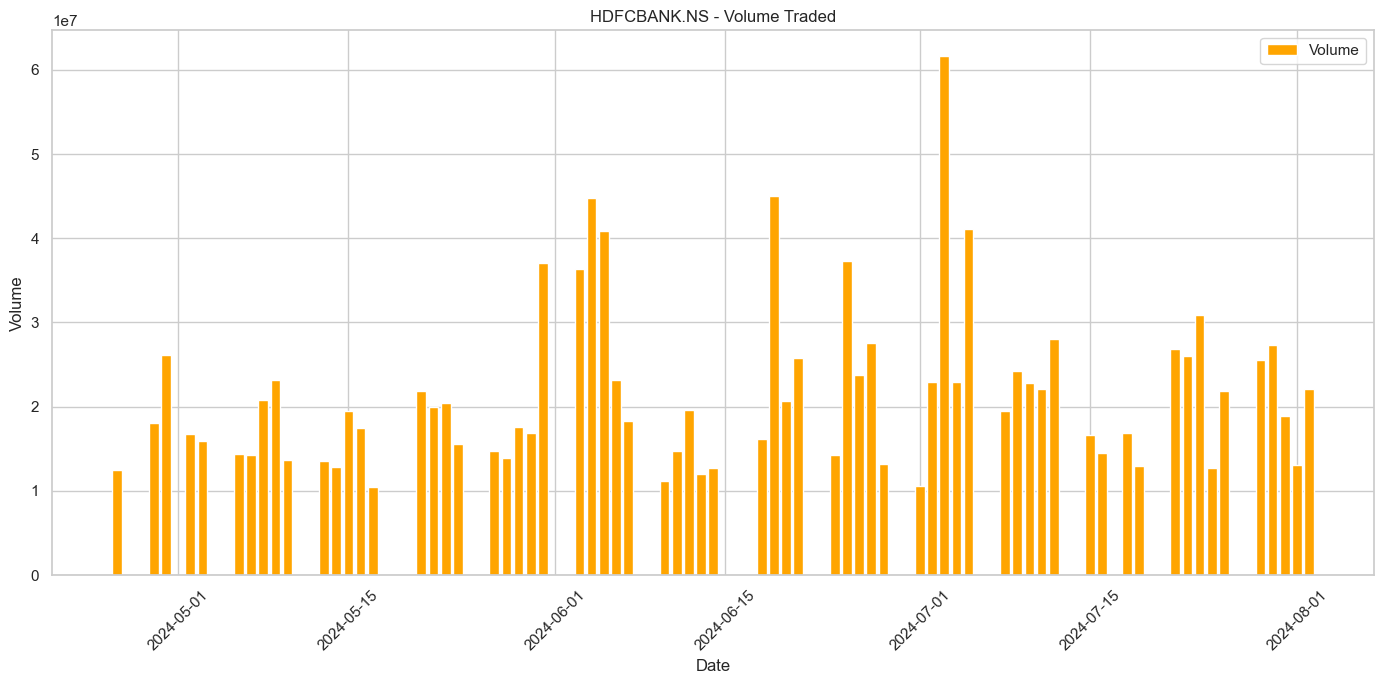

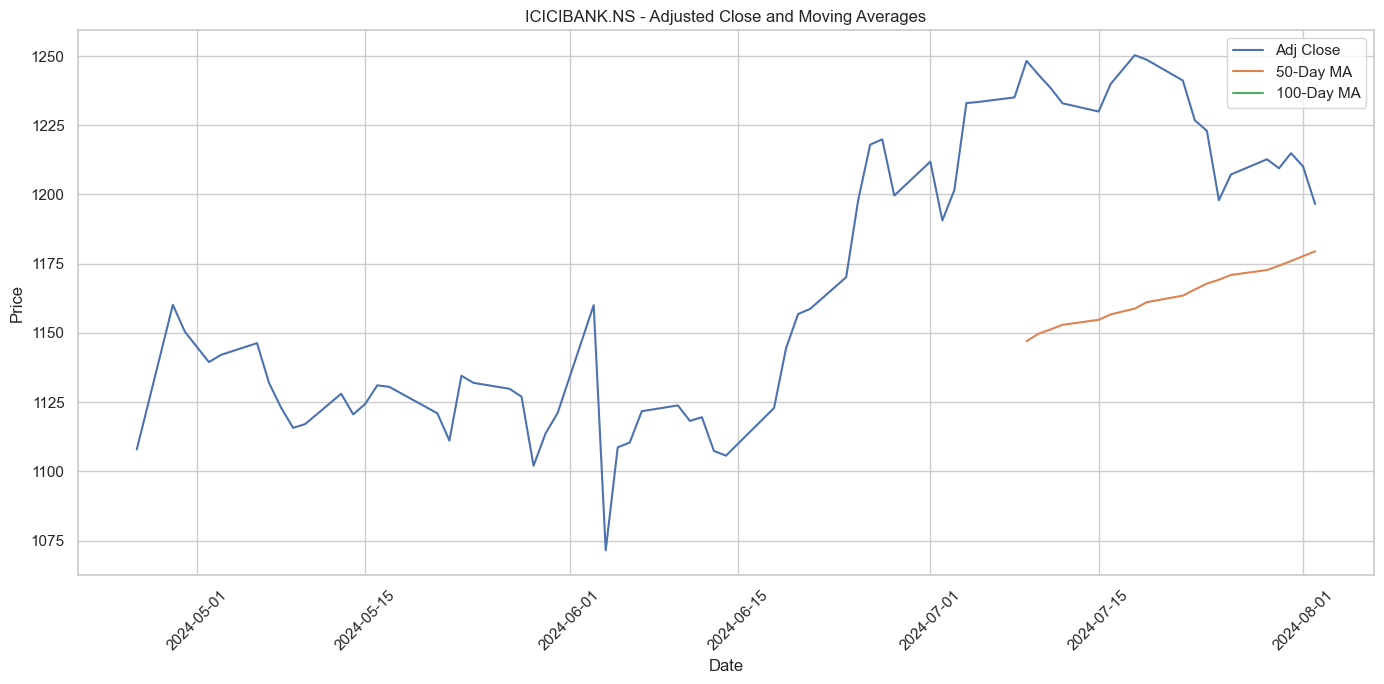

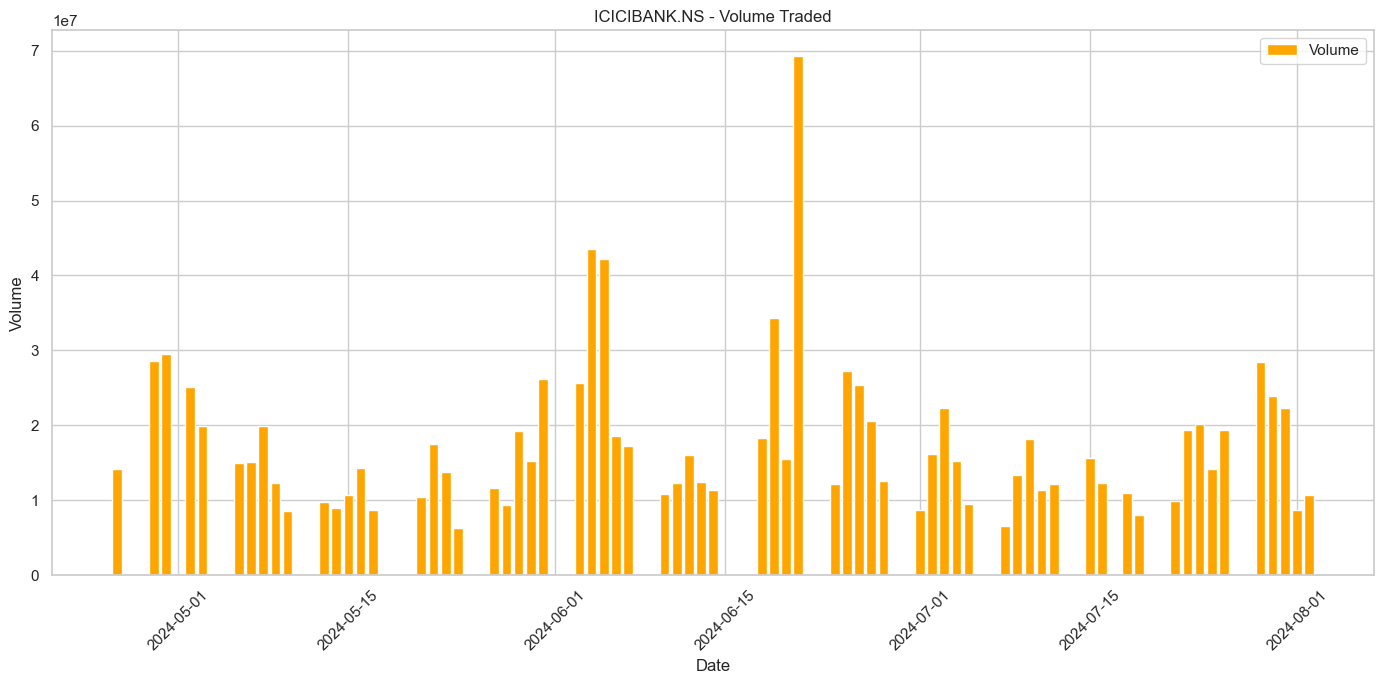

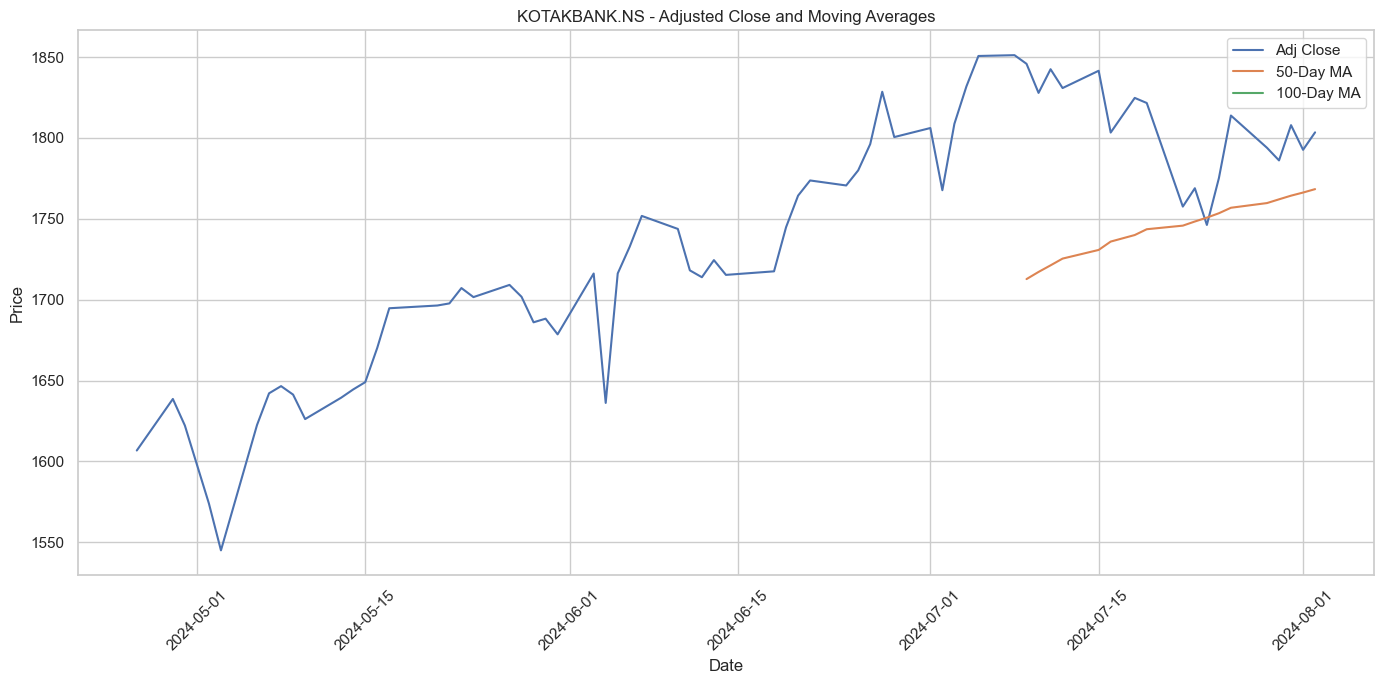

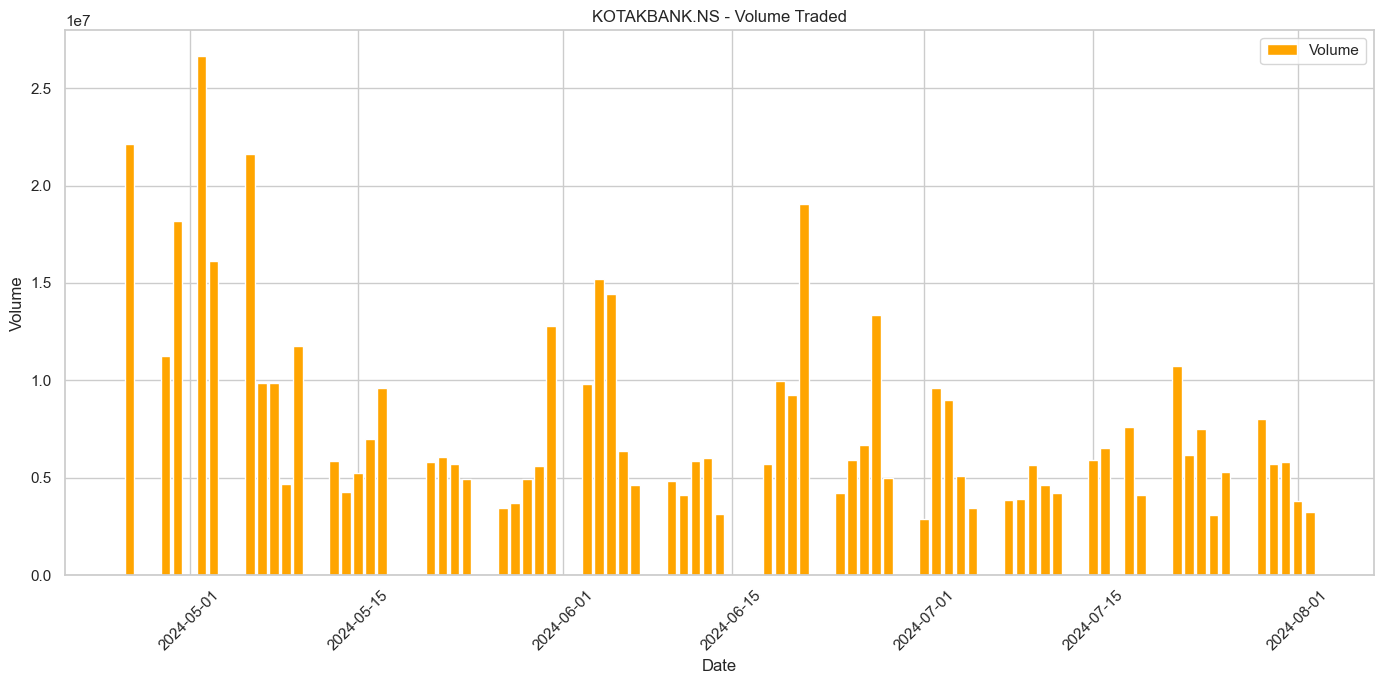

In [78]:
short_window = 50
long_window = 100

stock_data.set_index('Date', inplace=True)
unique_tickers = stock_data['Ticker'].unique()

for ticker in unique_tickers:
    ticker_data = stock_data[stock_data['Ticker'] == ticker].copy()
    ticker_data['50_MA'] = ticker_data['Adj Close'].rolling(window=short_window).mean()
    ticker_data['100_MA'] = ticker_data['Adj Close'].rolling(window=long_window).mean()

    plt.figure(figsize=(14, 7))
    plt.plot(ticker_data.index, ticker_data['Adj Close'], label='Adj Close')
    plt.plot(ticker_data.index, ticker_data['50_MA'], label='50-Day MA')
    plt.plot(ticker_data.index, ticker_data['100_MA'], label='100-Day MA')
    plt.title(f'{ticker} - Adjusted Close and Moving Averages')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(14, 7))
    plt.bar(ticker_data.index, ticker_data['Volume'], label='Volume', color='orange')
    plt.title(f'{ticker} - Volume Traded')
    plt.xlabel('Date')
    plt.ylabel('Volume')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

**Step 3:** Distribution of Daily return of stocks.


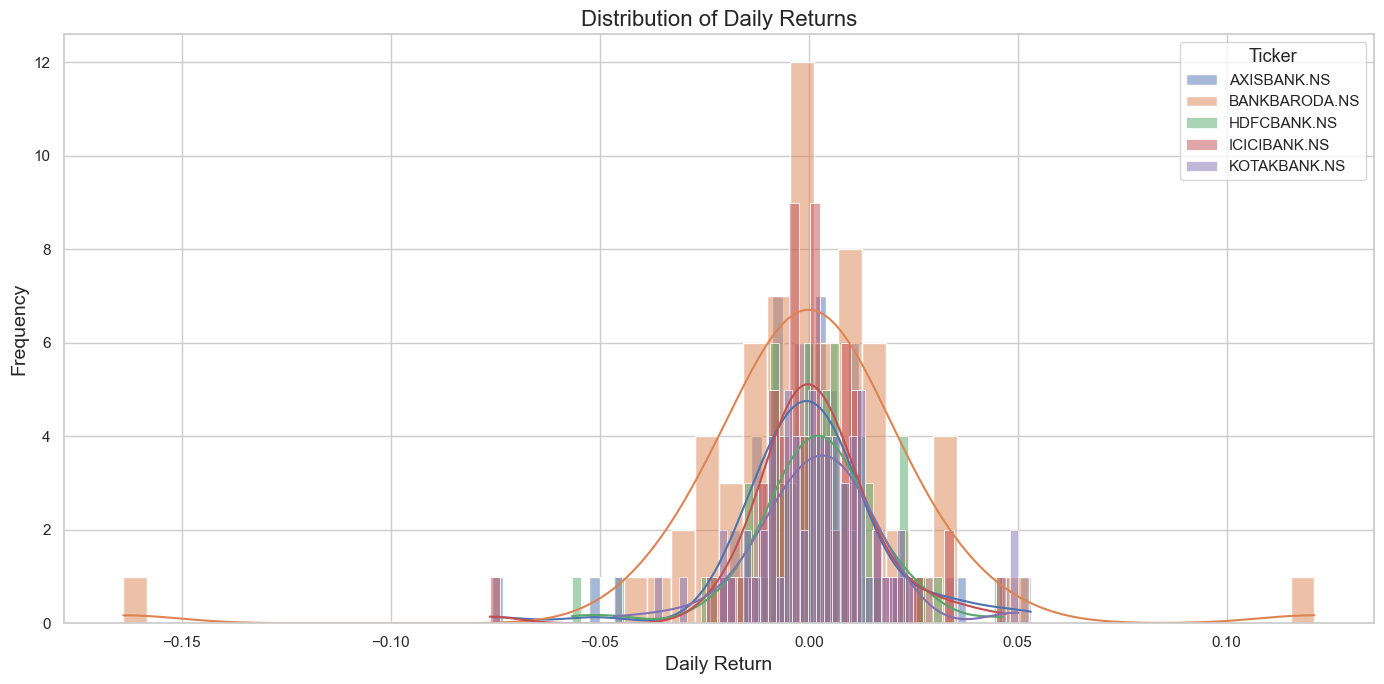

In [79]:
stock_data['Daily Return'] = stock_data.groupby('Ticker')['Adj Close'].pct_change()

plt.figure(figsize=(14, 7))
sns.set(style='whitegrid')

for ticker in unique_tickers:
    ticker_data = stock_data[stock_data['Ticker'] == ticker]
    sns.histplot(ticker_data['Daily Return'].dropna(), bins=50, kde=True, label=ticker, alpha=0.5)

plt.title('Distribution of Daily Returns', fontsize=16)
plt.xlabel('Daily Return', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend(title='Ticker', title_fontsize='13', fontsize='11')
plt.grid(True)
plt.tight_layout()
plt.show()

The distributions are approximately normal, centred around zero, which indicates that most daily returns are close to the average return. However, there are tails on both sides, which reflect occasional significant gains or losses. Bank Of Baroda appear to have slightly wider distributions, which suggests higher volatility compared to other stock.

**Step 4:** Correlation of the stocks.


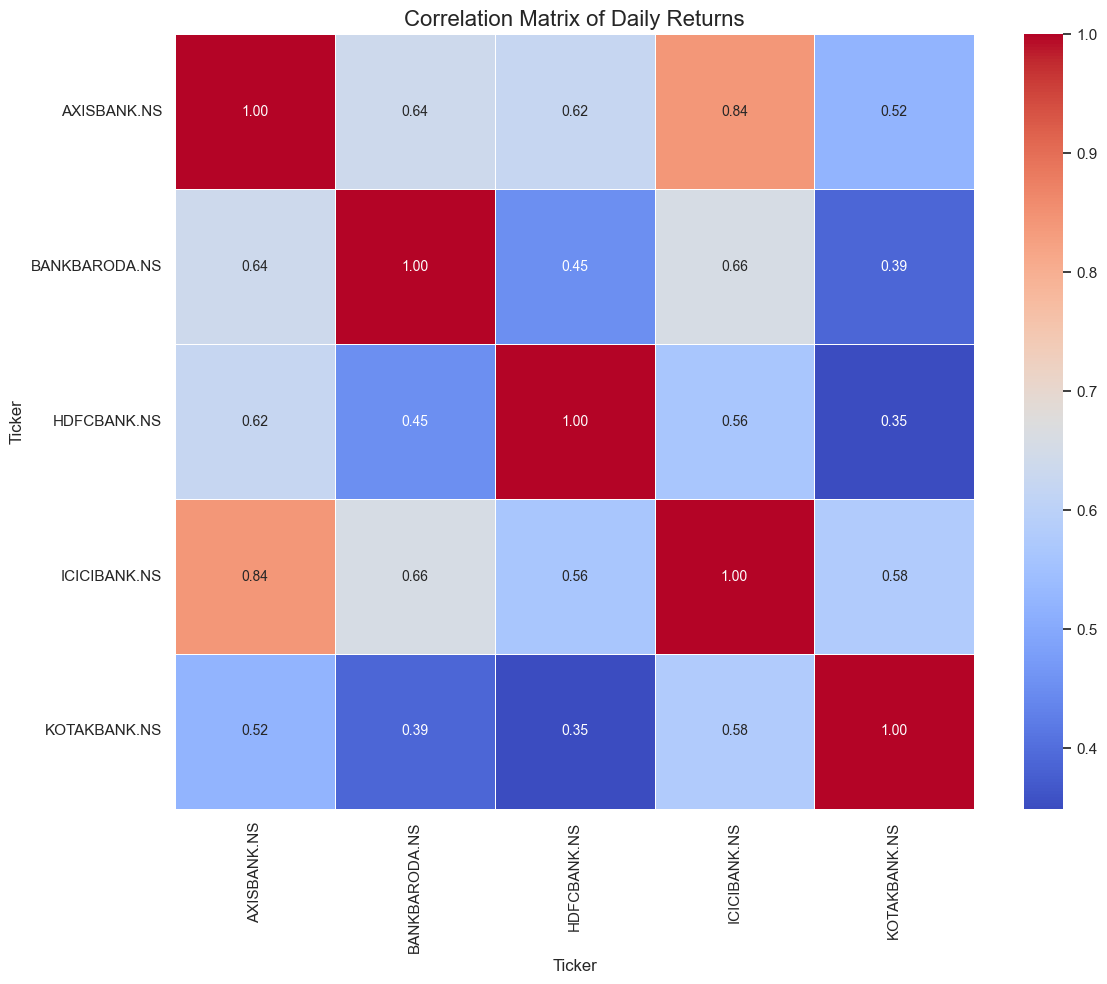

In [80]:
daily_returns = stock_data.pivot_table(index='Date', columns='Ticker', values='Daily Return')
correlation_matrix = daily_returns.corr()

plt.figure(figsize=(12, 10))
sns.set(style='whitegrid')

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5, fmt='.2f', annot_kws={"size": 10})
plt.title('Correlation Matrix of Daily Returns', fontsize=16)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

AXIS Bank and ICICI Bank has positive correlation (0.84). Indicating the strong relation of same direction between this two stocks. HDFC Bank and Kotak Bank have low correlation.

**Step 5:** Optimmization using MPT(Modern Portfolio Theory).


In [81]:
import numpy as np

expected_returns = daily_returns.mean() * 252  # annualize the returns
volatility = daily_returns.std() * np.sqrt(252)  # annualize the volatility

stock_stats = pd.DataFrame({
    'Expected Return': expected_returns,
    'Volatility': volatility
})

stock_stats

,Expected Return,Volatility
Ticker,,
AXISBANK.NS,0.147674,0.293937
BANKBARODA.NS,-0.136269,0.489285
HDFCBANK.NS,0.443059,0.249162
ICICIBANK.NS,0.326510,0.255136
KOTAKBANK.NS,0.472357,0.251121


All The stocks of BankNifty has Moderate volatility of an average 27%. The Return from Kotak Bank(47.23%) has Higher return with moderate risk, following by HDFC Bank (44.3%), ICICI Bank(32.65%). THe Axis Bank and Bank Of Baroda has significantly higher risk and low return.

**Step 6:** Visualization with expected Return and Volatility.
1. Generate a large number of random portfolio weights.
2. Calculate the expected return and volatility for each portfolio.
3. Plot these portfolios to visualize the efficient frontier.


C:\Users\Jay Suryawanshi\AppData\Local\Temp\ipykernel_19268\1954045446.py:33: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(label='Sharpe Ratio')


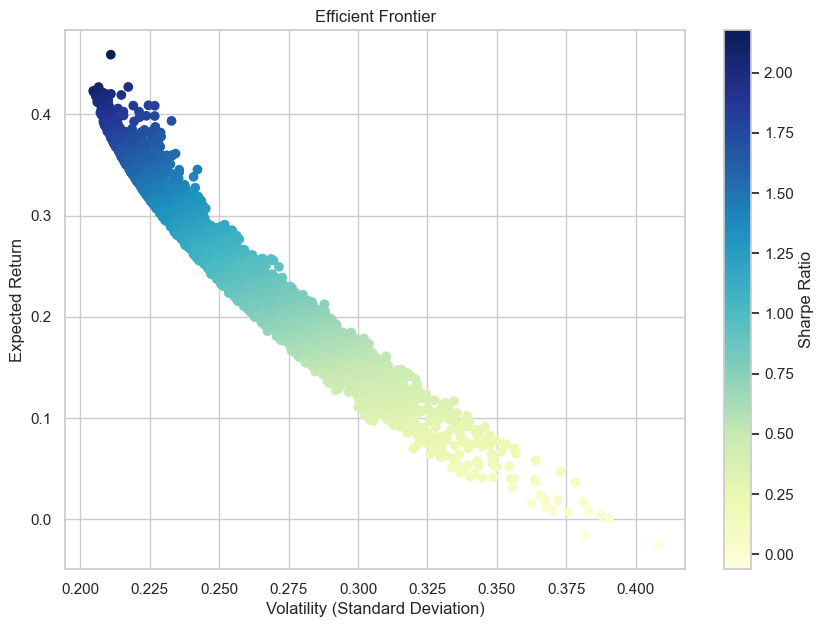

In [82]:
# function to calculate portfolio performance
def portfolio_performance(weights, returns, cov_matrix):
    portfolio_return = np.dot(weights, returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return portfolio_return, portfolio_volatility

# number of portfolios to simulate
num_portfolios = 10000

# arrays to store the results
results = np.zeros((3, num_portfolios))

# annualized covariance matrix
cov_matrix = daily_returns.cov() * 252

np.random.seed(42)

for i in range(num_portfolios):
    weights = np.random.random(len(unique_tickers))
    weights /= np.sum(weights)

    portfolio_return, portfolio_volatility = portfolio_performance(weights, expected_returns, cov_matrix)

    results[0,i] = portfolio_return
    results[1,i] = portfolio_volatility
    results[2,i] = portfolio_return / portfolio_volatility  # Sharpe Ratio

plt.figure(figsize=(10, 7))
plt.scatter(results[1,:], results[0,:], c=results[2,:], cmap='YlGnBu', marker='o')
plt.title('Efficient Frontier')
plt.xlabel('Volatility (Standard Deviation)')
plt.ylabel('Expected Return')
plt.colorbar(label='Sharpe Ratio')
plt.grid(True)
plt.show()

Each dot represents a portfolio, with the colour indicating the Sharpe ratio, a measure of risk-adjusted return. Portfolios on the leftmost edge of the frontier (closer to the y-axis) offer the highest expected returns for a given level of volatility, which represent optimal portfolios. The gradient shows that portfolios with higher Sharpe ratios (darker blue) provide better risk-adjusted returns.


**Step 7:** Sharpe ratio of Portfolio and each stocks

In [86]:
max_sharpe_idx = np.argmax(results[2])
max_sharpe_return = results[0, max_sharpe_idx]
max_sharpe_volatility = results[1, max_sharpe_idx]
max_sharpe_ratio = results[2, max_sharpe_idx]

max_sharpe_return, max_sharpe_volatility, max_sharpe_ratio

(0.45902719131809755, 0.21095996792559488, 2.1758971421535076)

The portfolio with the maximum Sharpe ratio has the following characteristics:

Expected Return: ~45.9%
Volatility: ~21.09%
Sharpe Ratio: ~2.17

In [84]:
max_sharpe_weights = np.zeros(len(unique_tickers))

for i in range(num_portfolios):
    weights = np.random.random(len(unique_tickers))
    weights /= np.sum(weights)

    portfolio_return, portfolio_volatility = portfolio_performance(weights, expected_returns, cov_matrix)

    if results[2, i] == max_sharpe_ratio:
        max_sharpe_weights = weights
        break

portfolio_weights_df = pd.DataFrame({
    'Ticker': unique_tickers,
    'Weight': max_sharpe_weights
})

portfolio_weights_df

,Ticker,Weight
0,AXISBANK.NS,0.449904
1,BANKBARODA.NS,0.051946
2,HDFCBANK.NS,0.210861
3,ICICIBANK.NS,0.020166
4,KOTAKBANK.NS,0.267123


The output shows a diversified portfolio with the following allocations:
1.	AXISBANK (44.99%)
2.	BANKBARODA (51.946%)
3.	HDFCBANK	(21.08%)
4.	ICICIBANK (20.16%)
5.	KOTAKBANK (26.71%)
Bank Of Baroda has the highest allocation, which indicates its significant contribution to the portfolio’s performance, while ICICI Bank has the smallest allocation. This balanced allocation aims to maximize returns while significant risk by leveraging individual stock performances and their correlations.
